In [1]:
import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.lines import Line2D

In [2]:
run_dir = "/mnt/lustre/cornell/yzs2/runs/dllm-dev"
bd3lm_dir = "gsm8k-0shot_block4_lr1e-5_bsz1_warm100ba_alphaf0.5_max-dur30000ba_amp_bf16_layers{N}_bd3lm"
e2d2_dir = "gsm8k-0shot_block4_lr1e-5_bsz1_warm100ba_alphaf0.5_max-dur30000ba_amp_bf16_enc28_TOPdec{N}_e2d2_tie-weights"

In [3]:
bd3lm_results = {}
bd3lm_N = [10, 14, 17, 21, 28]
for n in bd3lm_N:
    for d in os.listdir(
        os.path.join(run_dir, bd3lm_dir.format(N=n), "lm_eval_harness_output")
    ):
        if "metrics.txt" in os.listdir(
            os.path.join(run_dir, bd3lm_dir.format(N=n), "lm_eval_harness_output", d)
        ):
            with open(
                os.path.join(
                    run_dir,
                    bd3lm_dir.format(N=n),
                    "lm_eval_harness_output",
                    d,
                    "metrics.txt",
                ),
                "r",
            ) as f:
                lines = f.readlines()
                # print("".join(lines))
                for line in lines:
                    if "flexible-extract" in line:
                        bd3lm_results[n] = {
                            "Accuracy": float(line.split("|±")[0].split("|")[-1]) * 100
                        }
        if "throughput-rank0.json" in os.listdir(
            os.path.join(run_dir, bd3lm_dir.format(N=n), "lm_eval_harness_output", d)
        ):
            with open(
                os.path.join(
                    run_dir,
                    bd3lm_dir.format(N=n),
                    "lm_eval_harness_output",
                    d,
                    "throughput-rank0.json",
                ),
                "r",
            ) as f:
                tput = json.load(f)
                bd3lm_results[n]["Throughput"] = tput["throughput_mean"]

In [4]:
e2d2_results = {}
e2d2_N = [6, 10, 14, 21, 26]
for n in e2d2_N:
    for d in os.listdir(
        os.path.join(run_dir, e2d2_dir.format(N=n), "lm_eval_harness_output")
    ):
        if "metrics.txt" in os.listdir(
            os.path.join(run_dir, e2d2_dir.format(N=n), "lm_eval_harness_output", d)
        ):
            with open(
                os.path.join(
                    run_dir,
                    e2d2_dir.format(N=n),
                    "lm_eval_harness_output",
                    d,
                    "metrics.txt",
                ),
                "r",
            ) as f:
                lines = f.readlines()
                # print("".join(lines))
                for line in lines:
                    if "flexible-extract" in line:
                        e2d2_results[n] = {
                            "Accuracy": float(line.split("|±")[0].split("|")[-1]) * 100
                        }
        if "throughput-rank0.json" in os.listdir(
            os.path.join(run_dir, e2d2_dir.format(N=n), "lm_eval_harness_output", d)
        ):
            with open(
                os.path.join(
                    run_dir,
                    e2d2_dir.format(N=n),
                    "lm_eval_harness_output",
                    d,
                    "throughput-rank0.json",
                ),
                "r",
            ) as f:
                tput = json.load(f)
                e2d2_results[n]["Throughput"] = tput["throughput_mean"]

In [5]:
bd3lm_df = pd.DataFrame(bd3lm_results).T.reset_index(names="Layers")
bd3lm_df["Model"] = "BD3LM"
bd3lm_df

,Layers,Accuracy,Throughput,Model
0,10,5.53,150.226803,BD3LM
1,14,10.08,116.338689,BD3LM
2,17,16.38,102.147306,BD3LM
3,21,33.21,86.572976,BD3LM
4,28,48.60,67.500656,BD3LM


In [6]:
e2d2_df = pd.DataFrame(e2d2_results).T.reset_index(names="Layers")
e2d2_df["Model"] = "E2D2"
e2d2_df

,Layers,Accuracy,Throughput,Model
0,6,32.68,147.671006,E2D2
1,10,39.12,119.440881,E2D2
2,14,47.92,102.776351,E2D2
3,21,51.33,81.608861,E2D2
4,26,52.16,71.097726,E2D2


In [7]:
df = pd.concat([bd3lm_df, e2d2_df]).reset_index(names="Regime")
df

,Regime,Layers,Accuracy,Throughput,Model
0,0,10,5.53,150.226803,BD3LM
1,1,14,10.08,116.338689,BD3LM
2,2,17,16.38,102.147306,BD3LM
3,3,21,33.21,86.572976,BD3LM
4,4,28,48.60,67.500656,BD3LM
5,0,6,32.68,147.671006,E2D2
6,1,10,39.12,119.440881,E2D2
7,2,14,47.92,102.776351,E2D2
8,3,21,51.33,81.608861,E2D2
9,4,26,52.16,71.097726,E2D2


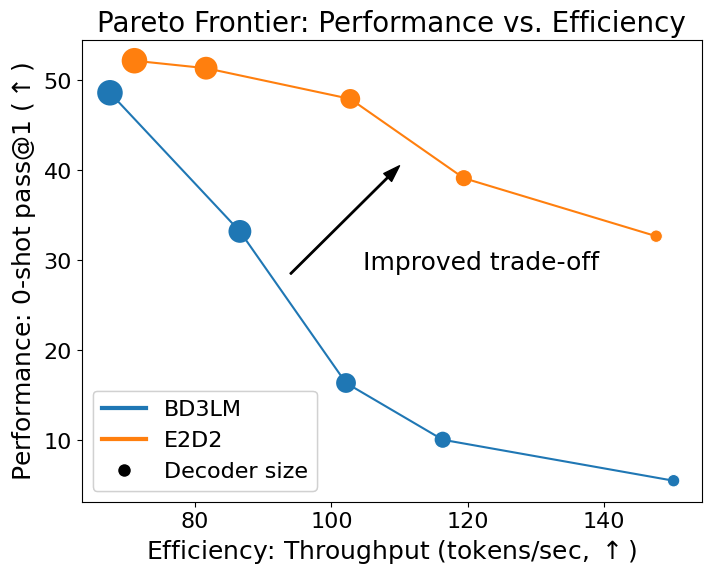

In [22]:
# Plot
plt.figure(figsize=(8, 6))

# Scatter for each regime separately so we can control marker shape
for regime in df.Regime.unique():  # regime_markers.items():
    subset = df[df["Regime"] == regime]
    sns.scatterplot(
        data=subset,
        x="Throughput",
        y="Accuracy",
        hue="Model",
        s=regime * 80 + 80,  # 120, #regime_sizes[regime],
        # marker=marker,
        legend=False,
    )

# Lines for each model to show Pareto frontiers
df_sorted = df.sort_values(by=["Model", "Throughput"], ascending=[True, False])
sns.lineplot(data=df_sorted, x="Throughput", y="Accuracy", hue="Model", legend=False)

# Custom legends
model_legend = [
    Line2D([0], [0], color=sns.color_palette()[0], lw=3, label="BD3LM"),
    Line2D([0], [0], color=sns.color_palette()[1], lw=3, label="E2D2"),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="k",
        markersize=10,
        label="Decoder size",
        linestyle="",
    ),
]

# Add legends separately
legend1 = plt.legend(handles=model_legend, loc="lower left", fontsize=16)
plt.gca().add_artist(legend1)

# Labels and grid
plt.title("Pareto Frontier: Performance vs. Efficiency", fontsize=20)
plt.xlabel(r"Efficiency: Throughput (tokens/sec, $\uparrow$)", fontsize=18)
plt.ylabel(r"Performance: 0-shot pass@1 ($\uparrow$)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.grid(True)


# Add arrow annotation for improved trade-off
plt.annotate(
    text="",
    xy=(112, 42),  # arrow head
    xytext=(92, 27),  # arrow tail
    arrowprops=dict(
        facecolor="black",
        shrink=0.1,
        width=1,
        headwidth=8,
    ),
    fontsize=10,
    ha="center",
)
plt.text(
    122,
    29,  # x,y location of text label
    "Improved trade-off",
    fontsize=18,
    ha="center",
)
plt.savefig("pareto_frontier.pdf")
plt.show()